(HW6)=
# HW6

In this task you are suggested to implement gradient descent and Newton's optimization methods, and investigate their performance for three types of functions:

* quadratic function
* loss function of linear regression
* loss function of logistic regression

`BaseSmoothOracle` is an abstract class for objective function $f$ (**oracle**). Each concrete oracle must inherit this class, implementing four methods:

* `func(x)` calculates $f(\boldsymbol x)$
* `grad(x)` calculates $\nabla f(\boldsymbol x)$
* `hess(x)` calculates $\nabla^2 f(\boldsymbol x)$
* `get_opt(x)` calculates point of minimum by direct formula (works only for quadratic and linear regression oracles)

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
from sklearn.model_selection import train_test_split

In [2]:
class BaseSmoothOracle(object):
    """
    Base class for implementation of oracles.
    """
    def func(self, x):
        """
        Computes the value of function at point x.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, x):
        """
        Computes the gradient at point x.
        """
        raise NotImplementedError('Grad oracle is not implemented.')
    
    def hess(self, x):
        """
        Computes the Hessian matrix at point x.
        """
        raise NotImplementedError('Hessian oracle is not implemented.')
        
    def get_opt(self):
        """
        Computes the point x at which minimum is attained
        """
        raise NotImplementedError('True solution is unavailable.')

## Quadratic oracle
:label: quadratic-oracle
$
    f(\boldsymbol x) = \frac 12 \boldsymbol x^\mathsf{T} \boldsymbol{Ax} - \boldsymbol b^\mathsf{T} \boldsymbol x, \quad \boldsymbol A^\mathsf{T}  = \boldsymbol A \in \mathbb R^{n\times n}, \quad \boldsymbol b\in\mathbb R^n
$

### Task 6.1 (0.5 points)

Let $\boldsymbol A$ be a symmetric positive definite matrix. Solve the optimization task

$$
    \frac 12 \boldsymbol x^\mathsf{T} \boldsymbol{Ax} - \boldsymbol b^\mathsf{T}\boldsymbol x \to \min\limits_{\boldsymbol x \in \mathbb R^n}
$$

analytically.

#### SOLUTION 
We can find the critical points of the function and then identify which of these points correspond to the minimum.

To find the critical points, we need to compute the gradient of the function and set it to zero:
$$
\nabla  f(\mathbf{x}) = \nabla (\frac{1}{2} \mathbf{x}^\mathsf{T} \mathbf{Ax} - \mathbf{b}^\mathsf{T}\mathbf{x}) = 0
\\
\nabla f(\mathbf{x}) = \mathbf{Ax} - \mathbf{b} = 0
$$
Since  $\mathbf{A}$ is symmetric positive definite matrix, it is invertible. 

$\therefore$ , we can solve for $\mathbf{x}$ by multiplying both sides by $\mathbf{A}^{-1}$:

$$
\mathbf{A^{-1}Ax} - \mathbf{A^{-1}b} = 0
 \\
\mathbf{x} = \mathbf{A}^{-1} \mathbf{b}
$$
Minimum $\mathbf{x}$ is $\mathbf{A}^{-1} \mathbf{b}$

### Task 6.2 (0.5 points)

Implement quadratic oracle {eq}`quadratic-oracle`.

In [3]:
import numpy as np

class QuadraticOracle(BaseSmoothOracle):
    """
    Oracle for quadratic function:
       func(x) = 1/2 x^TAx - b^Tx.
    """

    def __init__(self, A, b):
        if not np.allclose(A, A.T):
            raise ValueError('A should be a symmetric matrix.')
        self.A = A
        self.b = b

    def func(self, x):
        return 0.5 * np.dot(x.T, np.dot(self.A, x)) - np.dot(self.b.T, x)


    def grad(self, x):
        return np.dot(self.A, x) - self.b


    def hess(self, x):
        return self.A
    
    def get_opt(self):
        return np.linalg.inv(self.A) @ self.b

In [4]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

def plot_levels(func, xrange=None, yrange=None, levels=None):
    """
    Plotting the contour lines of the function.

    Example:
    --------
    >> oracle = QuadraticOracle(np.array([[1.0, 2.0], [2.0, 5.0]]), np.zeros(2))
    >> plot_levels(oracle.func)
    """
    if xrange is None:
        xrange = [-6, 6]
    if yrange is None:
        yrange = [-5, 5]
    if levels is None:
        levels = [0, 0.25, 1, 4, 9, 16, 25]
        
    x = np.linspace(xrange[0], xrange[1], 100)
    y = np.linspace(yrange[0], yrange[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

    CS = plt.contour(X, Y, Z, levels=levels, colors='k')
    plt.clabel(CS, inline=1, fontsize=8) 
    plt.grid()   

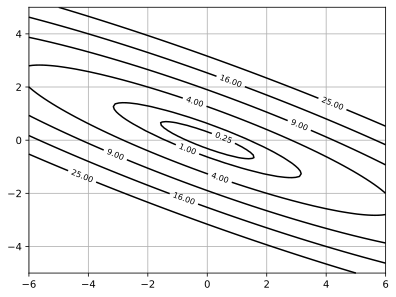

In [5]:
oracle = QuadraticOracle(np.array([[1.0, 2.0], [2.0, 5.0]]), np.zeros(2))
plot_levels(oracle.func)

## Linear regression oracle


### Task 6.3 (0.5 points)

Implement linear regression oracle

$$
    f(\boldsymbol x) = \frac 1m \Vert \boldsymbol{Ax} - \boldsymbol b\Vert_2^2, \quad \boldsymbol A \in \mathbb R^{m\times n}, \quad \boldsymbol b \in \mathbb R^n
$$

#### Optimal $x$
$$
    f(\boldsymbol x) = \frac 1m \Vert \boldsymbol{Ax} - \boldsymbol b\Vert_2^2
    \\
    \nabla  \frac 1m \Vert \boldsymbol{Ax} - \boldsymbol b\Vert_2^2 
    \\
    =  \frac 2m \boldsymbol A^T(\boldsymbol A \boldsymbol x - \boldsymbol b)
    \\
    \frac 2m \boldsymbol A^T \boldsymbol A \boldsymbol x -  \frac 2m \boldsymbol A^T \boldsymbol b = 0
    \\
    = (\frac 2m \boldsymbol A^T \boldsymbol A)^{-1} \frac 2m \boldsymbol A^T \boldsymbol A \boldsymbol x - (\frac 2m \boldsymbol A^T \boldsymbol A)^{-1} \frac 2m \boldsymbol A^T \boldsymbol b = 0
    \\
    \boldsymbol x = (\frac 2m \boldsymbol A^T \boldsymbol A)^{-1} \frac 2m \boldsymbol A^T \boldsymbol b
    \\
    = (\boldsymbol A^T \boldsymbol A)^{-1} \boldsymbol A^T \boldsymbol b
$$
When I solved gradient I used Transposed version of matrix $\boldsymbol A$, since the dimensionality is not a problem, when multiplying Transposed version($n \times m$) to untransposed version($m \times n$)

In [6]:
class LinRegOracle(BaseSmoothOracle):
    """
    Oracle for linear regression:
       func(x) = 1/m ||Ax - b||^2.
    """

    def __init__(self, A, b):
        self.A = A
        self.b = b
        self.m = A.shape[0]

    def func(self, x):
        residual = self.A.dot(x) - self.b
        return np.linalg.norm(residual) ** 2 / (2 * self.m)

    def grad(self, x):
        residual = self.A.dot(x) - self.b
        return self.A.T.dot(residual) / self.m

    def hess(self, x):
        return self.A.T.dot(self.A) / self.m

    def get_opt(self):
        return np.linalg.solve(self.A.T.dot(self.A), self.A.T.dot(self.b))

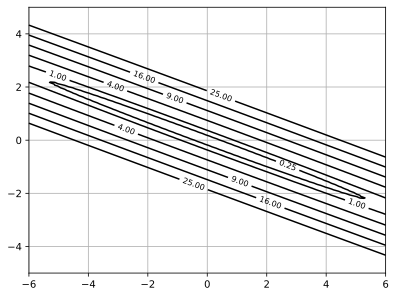

In [7]:
oracle = LinRegOracle(np.array([[1.0, 2.0], [2.0, 5.0]]), np.zeros(2))
plot_levels(oracle.func)

In [8]:
oracle.get_opt()

array([ 0., -0.])

## Logistic regression oracle


:label: log-reg-oracle
$$
    f(\boldsymbol x) = \frac 1m \sum_{i=1}^m \log\big(1 + \exp(-b_i\boldsymbol a_i^\mathsf{T} \boldsymbol x)\big) + \frac C2\Vert \boldsymbol x\Vert_2^2
$$

### Task 6.4 (0.5 points)

Show that {eq}`log-reg-oracle` is proportional to the loss function of {ref}`binary logistic regression <simple-log-reg>` model with targets denoted as $\pm 1$.

#### SOLUTION
The loss function for binary logistic regression is binary cross-entropy loss:
$$
\mathcal{L}(\boldsymbol{w}) = -\frac{1}{N} \sum_{i=1}^N \left( y_i \log(\sigma(\boldsymbol{w}^\top \boldsymbol{x}_i)) + (1 - y_i) \log(1 - \sigma(\boldsymbol{w}^\top \boldsymbol{x}_i)) \right)
$$
where:
- $\boldsymbol{w}$ are the weights of the logistic regression model,
-  $\boldsymbol{x}_i$  is the feature vector of the $i$-th sample,
- $y_i$ is the target label of the $i$-th sample (either $1$ or $-1$),
- $\sigma(z) = \frac{1}{1 + e^{-z}}$ is sigmoid function.
$$
\mathcal{L}(\boldsymbol{w}) = -\frac{1}{N} \sum_{i=1}^N \left( y_i \log(\sigma(\boldsymbol{w}^\top \boldsymbol{x}_i)) + (1 - y_i) \log(1 - \sigma(\boldsymbol{w}^\top \boldsymbol{x}_i)) \right)
\\
= -\frac{1}{N} \sum_{i=1}^N \left( y_i \log(\sigma(\boldsymbol{w}^\top \boldsymbol{x}_i)) + (1 - y_i) \log( \sigma(-\boldsymbol{w}^\top \boldsymbol{x}_i)) \right)
\\
= -\frac{1}{N} \sum_{i=1}^N \left( y_i \log(\frac {1}{1 + e ^{-\boldsymbol{w}^\top \boldsymbol{x}_i}}) + (1 - y_i) \log(\frac {1}{1 + e ^{\boldsymbol{w}^\top \boldsymbol{x}_i}}) \right)
\\
= \frac{1}{N} \sum_{i=1}^N \left( y_i \log({1 + e ^{-\boldsymbol{w}^\top \boldsymbol{x}_i}}) + (1 - y_i) \log(1 + e ^{\boldsymbol{w}^\top \boldsymbol{x}_i}) \right)
$$
* When target = 1 ($b_i$ = 1): 
$ f(\boldsymbol x) = \frac 1m \sum_{i=1}^m \log\big(1 + \exp(-\boldsymbol a_i^\mathsf{T} \boldsymbol x)\big) + \frac C2\Vert \boldsymbol x\Vert_2^2 $ 

Then correspondingly binary cross-entropy($y_i$ = 1): 
$ \mathcal{L}(\boldsymbol{w})\text{for ith element} = \frac{1}{N} \sum_{i=1}^N \log({1 + e ^{-\boldsymbol{w}^\top \boldsymbol{x}_i}}) $

* When target = -1 ($b_i$ = -1):
$ f(\boldsymbol x) = \frac 1m \sum_{i=1}^m \log\big(1 + \exp(\boldsymbol a_i^\mathsf{T} \boldsymbol x)\big) + \frac C2\Vert \boldsymbol x\Vert_2^2$

Then correspondingly binary cross-entropy($y_i$ = -1):
$\mathcal{L}(\boldsymbol{w})\text{for ith element}= \frac{1}{N} \sum_{i=1}^N \left(- \log({1 + e ^{-\boldsymbol{w}^\top \boldsymbol{x}_i}}) + 2  \log(1 + e ^{\boldsymbol{w}^\top \boldsymbol{x}_i}) \right)$.



Each log reg oracle is proportional to its target's binary logistic regression loss function

### Task 6.5 (1 point)

Find the gradient $\nabla f(\boldsymbol x)$ and hessian $\nabla^2 f(\boldsymbol x)$ of logistic regression oracle {eq}`log-reg-oracle` in matrix-vector form.

#### SOLUTION
Given the logistic regression oracle function:
$$
f(\boldsymbol{x}) = \frac{1}{m} \sum_{i=1}^m \log\left(1 + \exp(-b_i\boldsymbol{a}_i^\mathsf{T} \boldsymbol{x})\right) + \frac{C}{2}\|\boldsymbol{x}\|_2^2
$$

The gradient $\nabla f(\boldsymbol{x})$ with respect to $\boldsymbol{x}$ computed as follows:

1. Gradient of the first term:

$$
\nabla \left( \frac{1}{m} \sum_{i=1}^m \log\left(1 + \exp(-b_i\boldsymbol{a}_i^\mathsf{T} \boldsymbol{x})\right) \right) = \frac{1}{m} \sum_{i=1}^m \frac{1}{1 + \exp(-b_i\boldsymbol{a}_i^\mathsf{T} \boldsymbol{x})} \cdot (-b_i \boldsymbol{a}_i^T \exp(-b_i \boldsymbol{a}_i^\mathsf{T} \boldsymbol{x}))
$$

2. Gradient of the second term:

$$
\nabla \left( \frac{C}{2}\|\boldsymbol{x}\|_2^2 \right) = C \boldsymbol{x}
$$

$\therefore$, the total gradient $\nabla f(\boldsymbol{x})$ is the sum of the gradients of individual terms:

$$
\nabla f(\boldsymbol{x}) = \frac{1}{m} \sum_{i=1}^m \frac{-b_i \boldsymbol{a}_i^T \exp(-b_i\boldsymbol{a}_i^\mathsf{T} \boldsymbol{x})}{1 + \exp(-b_i\boldsymbol{a}_i^\mathsf{T} \boldsymbol{x})} + C \boldsymbol{x}
$$

Now, let's find the Hessian $\nabla^2 f(\boldsymbol{x})$:
$$
\nabla^2 f(\boldsymbol{x}) = \frac 1m \cdot (\frac{-b_i \boldsymbol{a}_i^T e^{(-b_i\boldsymbol{a}_i^\mathsf{T} \boldsymbol{x})} \cdot (-b_i a_i^T) (1 + e^{-b_i\boldsymbol{a}_i^\mathsf{T} \boldsymbol{x}}) - (- b_i a_i^T e^{-b_i\boldsymbol{a}_i^\mathsf{T} \boldsymbol{x}}) \cdot e^{-b_i\boldsymbol{a}_i^\mathsf{T} \boldsymbol{x}} \cdot (-b_i\boldsymbol{a}_i^\mathsf{T})}{(1 + e^{(-b_i\boldsymbol{a}_i^\mathsf{T} \boldsymbol{x})})^2}) + C \boldsymbol I
\\
= \frac 1m \cdot (\frac{-b_i^2 \boldsymbol{a}_i^{2T} e^{(-b_i\boldsymbol{a}_i^\mathsf{T} \boldsymbol{x})} + b_i^2 \boldsymbol{a}_i^{2T} e^{(-2 b_i\boldsymbol{a}_i^\mathsf{T} \boldsymbol{x})} - b_i^2 \boldsymbol{a}_i^{2T} e^{(-2 b_i\boldsymbol{a}_i^\mathsf{T} \boldsymbol{x})}}{(1 + e^{(-b_i\boldsymbol{a}_i^\mathsf{T} \boldsymbol{x})})^2}) + C \boldsymbol I
\\
= \frac 1m \cdot (\frac{-b_i^2 \boldsymbol{a}_i^{2T} e^{(-b_i\boldsymbol{a}_i^\mathsf{T} \boldsymbol{x})}}{(1 + e^{(-b_i\boldsymbol{a}_i^\mathsf{T} \boldsymbol{x})})^2}) + C \boldsymbol I
$$

### Task 6.6 (1 point)

Implement logistic regression oracle {eq}`log-reg-oracle`.

In [ ]:
# np.gradient()

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from scipy.special import expit

class LogRegOracle(BaseSmoothOracle):
    """
    Oracle for logistic regression.
    """

    def __init__(self, A, b, regcoef=1):
        self.A = A
        self.b = b
        self.C = regcoef

    def func(self, x):
        m = self.A.shape[0]
        return (np.sum(np.log(1 + np.exp(-self.b * (self.A @ x)))) / m +
                (self.C / 2) * np.linalg.norm(x)**2)


    def grad(self, x):
        m = self.A.shape[0]
        exp_term = np.exp(-self.b * (self.A @ x))
        return (-((self.b * self.A.T) @ (exp_term / (1 + exp_term))) / m +
                self.C * x)

    def hess(self, x):
        m = self.A.shape[0]
        exp_term = np.exp(self.b * (self.A @ x))
        diag = (exp_term / (1 + exp_term)**2)
        return (((self.A.T * diag) @ self.A) / m +
                np.eye(len(x)) * self.C)

        
    
    def get_opt(self):
        """
        Since there is no analytic solution for the optimal weights of logistic regression, 
        here we have to cheat a bit
        """
        LR = LogisticRegression(fit_intercept=False, C= 1./self.C/self.A.shape[0])
        LR.fit(self.A, (self.b + 1) / 2)
        return LR.coef_[0]

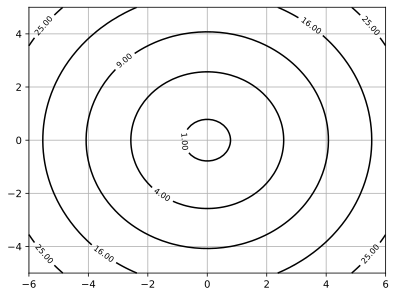

In [10]:
oracle = LogRegOracle(np.array([[1.0, 2.0], [2.0, 5.0]]), np.zeros(2))
plot_levels(oracle.func)

In [11]:
oracle.hess(np.array([1, 2]))

array([[1.625, 1.5  ],
       [1.5  , 4.625]])

## Gradient descent

Given a starting point $\boldsymbol x_0 \in\mathbb R^n$ and learning rate $\eta > 0$, iteratively calculate

$$
    \boldsymbol x_{k+1} = \boldsymbol x_k - \eta \nabla f(\boldsymbol x_k), \quad k = 0, 1,\ldots
$$

The process should stop when either $k = \mathrm{max\_iter}$ or 

$$
\Vert \nabla f(\boldsymbol x_k)\Vert_2^2 \leqslant \varepsilon \Vert \nabla f(\boldsymbol x_0)\Vert_2^2
$$

where $\varepsilon > 0$ is tolerance.

### Task 6.7 (1 point)

Complete the implementation of gradient descent algorithm.

In [12]:
from datetime import datetime
from collections import defaultdict

def gradient_descent(oracle, x_0, learning_rate=0.1, tolerance=1e-5, max_iter=10000,
                     trace=False, display=False):
    """
    Gradient descent optimization method.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively.
    x_0 : np.array
        Starting point for optimization algorithm.
    learning_rate : float
        Learning rate.
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.
        Printing format and is up to a student and is not checked in any way.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        "success" or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time in seconds passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2

    Example:
    --------
    >> oracle = QuadraticOracle(np.eye(5), np.arange(5))
    >> x_opt, message, history = gradient_descent(oracle, np.zeros(5))
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.  1.  2.  3.  4.]
    """
    history = defaultdict(list) if trace else None
    x_k = np.copy(x_0)
    grad_at_x_0 = oracle.grad(x_0)

    INF = 1e100
    start_time = datetime.now()

    for i in range(max_iter + 1):     
        grad_at_x_k = oracle.grad(x_k)
        if np.any(np.abs(x_k) > INF) or np.any(np.abs(grad_at_x_k) > INF):
            return x_k, 'computational_error', history

        if trace:
            history['time'].append((datetime.now() - start_time).microseconds * 1e-6)
            history['func'].append(oracle.func(x_k))
            history['grad_norm'].append(np.linalg.norm(grad_at_x_k))
            if x_k.shape[0] <= 2:
                history['x'].append(np.array(x_k))

        if display:
            print("iteration {}: |x_k-x_0| = {}, f(x_k) = {}, |grad(f(x_k))| = {}".format(
                i, np.linalg.norm(x_k - x_0), oracle.func(x_k), np.linalg.norm(grad_at_x_k))
            )
        x_k = x_k - learning_rate * grad_at_x_k

        if np.linalg.norm(grad_at_x_k) < tolerance:
            if display:
                print("Converged after {} iterations.".format(i))
            return x_k, 'success', history

    return x_k, 'iterations_exceeded', history
     

In [13]:
oracle = QuadraticOracle(np.eye(5), np.arange(5))
x_opt, message, history = gradient_descent(oracle, np.zeros(5))
print('Found optimal point: {}'.format(x_opt))

Found optimal point: [0.         0.99999846 1.99999691 2.99999537 3.99999382]


Now it's try to test gradient descent algorithm on different tasks. Here is some auxiliary code for visualization.

In [14]:
import colorsys

def get_color_array(size):
    HSV_tuples = [(float(i) / size, 1.0, 1.0) for i in range(size)]
    RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    return np.array(RGB_tuples)

def plot_2d(history, oracle, x_0, x_opt, scale, title, n_levels=3, xlims=None, ylims=None, bound=None):
    if bound is not None:
        history['x'] = history['x'][:bound]
    hist_x = np.array(history['x']).T
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    
    plt.plot(np.linalg.norm(hist_x - x_opt[:, None], axis=0), c='c', linewidth=3)
    plt.plot(history['grad_norm'], c='m', linewidth=2)
    plt.xlim(0, len(history['grad_norm']) - 1)
    plt.ylim(0, 2)
    plt.title(title)
    plt.ylabel('Gradients/residuals norm')
    plt.xlabel('Iteration')
    plt.legend(['Residuals', 'Gradients'])
    plt.grid(ls=":")
    
    plt.subplot(122)
    if xlims is not None:
        x_range = xlims
    else:
        x_range = [x_opt[0] - scale, x_opt[0] + scale]
    if ylims is not None:
        y_range = ylims
    else:
        y_range = [x_opt[1] - scale, x_opt[1] + scale]
    func_opt = oracle.func(x_opt)
    levels = [func_opt + 0.25 * scale / n_levels * i for i in range(1, 4*n_levels + 1, 4)]
    # sizes = np.minimum(5 * float(hist_x.shape[1]) / (np.arange(1, hist_x.shape[1] + 1)), 20)
    plt.scatter(hist_x[0], hist_x[1], s=8, c=get_color_array(hist_x.shape[1]))
    plt.plot(hist_x[0], hist_x[1], alpha=0.6, ls="--", c='r')
    # plt.plot(hist_x[0], hist_x[1], c='r', linewidth=3)
    plt.scatter(x_opt[0], x_opt[1], marker='s', c='r', edgecolors='k')
    plot_levels(oracle.func, xrange=x_range, yrange=y_range, levels=levels)
    plt.title('Trajectory')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(ls=":")
    if xlims is not None:
        plt.xlim(xlims)
    if ylims is not None:
        plt.ylim(ylims)
    plt.show()

def test_2d(method, oracle, x_0, lr, tol=1e-5, scale=1.0, xlims=None, ylims=None, bound=None):
    x_opt = oracle.get_opt()
    if method == 'gd':
        x_star, msg, history = gradient_descent(
            oracle, x_0, lr, tol, trace=True
        )
    elif method == 'newton':
        x_star, msg, history = newton(
            oracle, x_0, lr, tol, trace=True
        )
    else:
        raise ValueError("Unknown error")
    print(msg, len(history['grad_norm']), "iterations")
    plot_2d(history, oracle, x_0, x_opt, scale, 'lr = {}'.format(lr), xlims=xlims, ylims=ylims, bound=bound)

Take a simple quadratic function

$$
    f(x, y) = 2x^2 + 4xy + 5 y^2
$$

which ovbiously has minimum at $(0, 0)$. Now run gradient descent method with $\eta = 0.01$, starting from point $(-2, -1)$:

success 1176 iterations


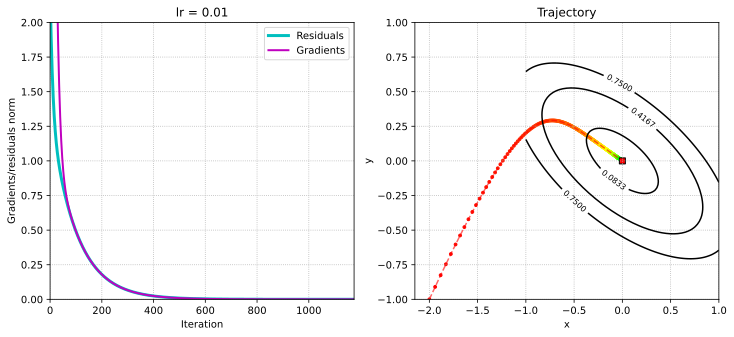

In [15]:
A = np.array([[2, 2], [2, 5]])
b = np.zeros(2)
q_oracle = QuadraticOracle(A, b)
test_2d("gd", q_oracle, np.array([-2.0, -1.0]), lr=0.01)

If you did all correctly, gradient descent should converge here to optimal point. But this is not always the case:

* if $\eta$ is very small, convergence could be too slow
* if $\eta$ is very big, than gradient descent often diverges

### Task 6.8 (1 point)

Take previous quadratic oracle and try different learning rates and starting points. Find the smallest and the largest learning rates for which gradient descent is still convergent. Provide some characteristic plots. Also, plot a graph of required iterations versus $\eta$.

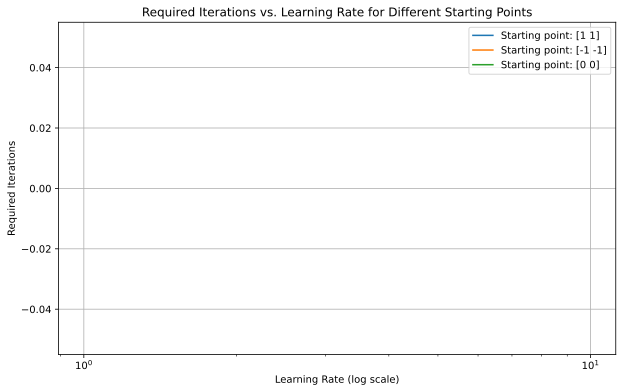

In [16]:
# Define the experiment function
def experiment(oracle, learning_rates, starting_points):
    results = []

    for lr in learning_rates:
        for x_0 in starting_points:
            x_opt, message, history = gradient_descent(oracle, x_0, learning_rate=lr)
            iterations = len(history['func']) if history is not None else -1
            results.append((lr, iterations))

    return results

# Define a range of learning rates to test
learning_rates = np.logspace(-5, 0, num=50)

# Define different starting points
starting_points = [np.array([1, 1]), np.array([-1, -1]), np.array([0, 0])]

# Create a QuadraticOracle instance
A = np.eye(2)  # Example symmetric matrix A
b = np.array([1, 1])  # Example vector b
oracle = QuadraticOracle(A, b)

# Perform the experiment
results = experiment(oracle, learning_rates, starting_points)

# Plot the graph of required iterations versus learning rate
plt.figure(figsize=(10, 6))
for x_0 in starting_points:
    iterations = [result[1] for result in results if result[0] > 0 and result[1] != -1]
    lr_values = [result[0] for result in results if result[0] > 0 and result[1] != -1]
    plt.plot(lr_values, iterations, label=f'Starting point: {x_0}')
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Required Iterations')
plt.title('Required Iterations vs. Learning Rate for Different Starting Points')
plt.legend()
plt.grid(True)
plt.show()


### GD for linear regression

Let's try it for simple linear regression. Here is a toy example:

success 1772 iterations


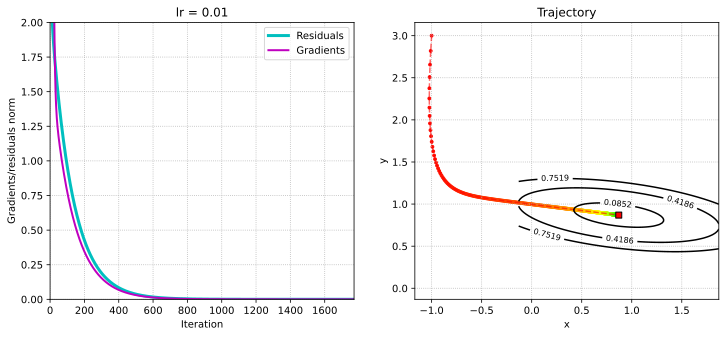

In [17]:
A = np.array([[1, -2.1], [1, 1.2], [1, 4.8]])
b = np.array([-1, 2, 5])
oracle = LinRegOracle(A, b)
test_2d("gd", oracle, np.array([-1, 3.0]), lr=0.01, tol=1e-6)

##### Task 6.9 (0.5 points)

Apply gradient descent algorithm to simple linear regression trained on `boston` dataset. Take `lstat` as feature, `medv` as target. Provide some visualizations.

C:\Users\acer\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i

success 2643 iterations


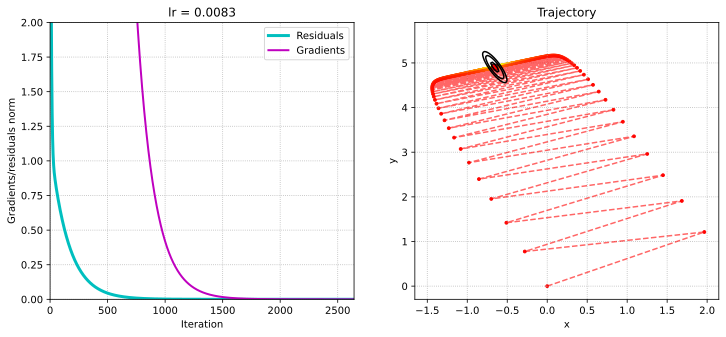

In [18]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston  # Import load_boston function

# Load the Boston dataset
boston = pd.DataFrame(load_boston().data, columns=load_boston().feature_names)
boston['MEDV'] = load_boston().target

# x_0 and learning_rate
x_0 = np.zeros(2)
learning_rate = 0.0083

# Drop NaN values
boston.dropna(inplace=True)

# Prepare features and target
feature = pd.DataFrame(np.c_[boston['LSTAT'], boston['RM']], columns=['LSTAT', 'RM']).values
target = boston['MEDV'].values

oracle = LinRegOracle(feature, target)  # You need to define LinRegOracle
# print(feature.shape)
# print(target.shape)
test_2d('gd', oracle, x_0, learning_rate)

### GD for logistic regression

The targets must be from $\{-1, 1\}$. One more toy example:

success 1202 iterations


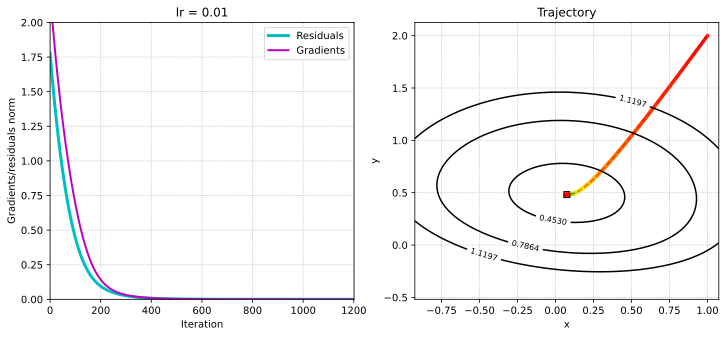

In [19]:
A = np.array([[1, -2.1], [1, 1.2], [1, 4.8], [1, 3.4]])
b = np.array([-1, 1, 1, 1])
oracle = LogRegOracle(A, b)
test_2d("gd", oracle, np.array([1., 2.0]), lr=0.01, tol=1e-6)

### Task 6.10 (0.5 points)

Train simple logistic regression model on `breast_cancer` dataset using your gradient descent method. Take any feature from the dataset. Visualize the results.

success 335 iterations


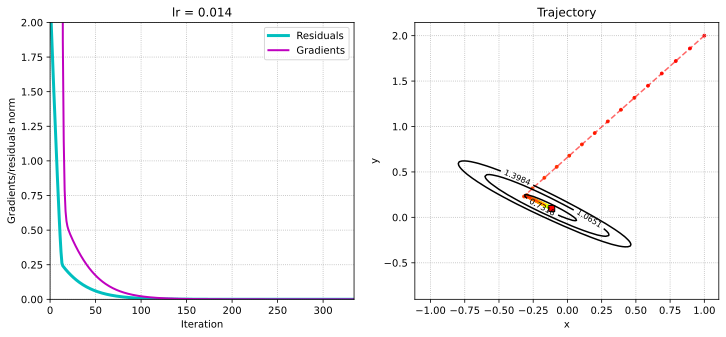

In [20]:
from sklearn.datasets import load_breast_cancer
breast = load_breast_cancer()
y = breast['target']
y[y == 0] = -1
X = breast.data[:, [0, 1]]
X = np.array(X)
y = np.array(y)
oracle = LogRegOracle(X, y)
test_2d("gd", oracle, np.array([1., 2.0]), lr=0.014, tol=1e-6)


## Newton's method

Given a starting point $\boldsymbol x_0 \in\mathbb R^n$ and learning rate $\eta > 0$, iteratively calculate

$$
    \boldsymbol x_{k+1} = \boldsymbol x_k - \eta \big(\nabla^2 f(\boldsymbol x_k)\big)^{-1} \nabla f(\boldsymbol x_k), \quad k = 0, 1,\ldots
$$

The process should stop when either $k = \mathrm{max\_iter}$ or 

$$
\Vert \nabla f(\boldsymbol x_k)\Vert_2^2 \leqslant \varepsilon \Vert \nabla f(\boldsymbol x_0)\Vert_2^2
$$

where $\varepsilon > 0$ is tolerance.

### Task 6.11 (1 point)

Complete the implementation of Newton's method.

In [21]:
import scipy

def newton(oracle, x_0, learning_rate=0.1, tolerance=1e-5, max_iter=10000, trace=False, display=False):
    """
    Newton's optimization method.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively. If the Hessian
        returned by the oracle is not positive-definite method stops with message="newton_direction_error"
    x_0 : np.array
        Starting point for optimization algorithm
    learning_rate : float
        Learning rate.
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        'success' or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'newton_direction_error': in case of failure of solving linear system with Hessian matrix (e.g. non-invertible matrix).
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2

    Example:
    --------
    >> oracle = QuadraticOracle(np.eye(5), np.arange(5))
    >> x_opt, message, history = newton(oracle, np.zeros(5), line_search_options={'method': 'Constant', 'c': 1.0})
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.  1.  2.  3.  4.]
    """
    history = defaultdict(list) if trace else None
    x_k = np.copy(x_0)
    grad_at_x_0 = oracle.grad(x_0)

    INF = 1e100
    start_time = datetime.now()

    for i in range(max_iter + 1): 
        grad_at_x_k = oracle.grad(x_k)
        hess_at_x_k = oracle.hess(x_k)  

        if np.any(np.abs(x_k) > INF) or np.any(np.abs(grad_at_x_k) > INF):
            return x_k, 'computational_error', history

        if trace:
            history['time'].append((datetime.now() - start_time).seconds)
            history['func'].append(oracle.func(x_k))
            history['grad_norm'].append(np.linalg.norm(grad_at_x_k))
            if x_k.shape[0] <= 2:
                history['x'].append(np.array(x_k))

        if display:
            print("iteration {}: |x_k-x_0| = {}, f(x_k) = {}, |grad(f(x_k))| = {}".format(
                i, np.linalg.norm(x_k - x_0), oracle.func(x_k), np.linalg.norm(grad_at_x_k))
            )

        # Compute Newton direction
        try:
            newton_direction = np.linalg.solve(hess_at_x_k, -grad_at_x_k)
        except np.linalg.LinAlgError:
            return x_k, 'newton_direction_error', history

        # Update x_k using Newton direction
        x_k = x_k + learning_rate * newton_direction

        # Stopping criterion
        if np.linalg.norm(grad_at_x_k) < tolerance:
            return x_k, 'success', history

    return x_k, 'iterations_exceeded', history

In [22]:
oracle = QuadraticOracle(np.eye(5), np.arange(5))
x_opt, message, history = newton(oracle, np.zeros(5))
print('Found optimal point: {}'.format(x_opt))

Found optimal point: [0.         0.99999846 1.99999691 2.99999537 3.99999382]


### Task 6.12 (1 point)

Apply Newton's methods to the previous tasks:

* quadratic function
* simple linear regression trained on `boston` dataset
* simple logistic regression trained on `breast_cancer` dataset

Compare the number of iterations and time execution of GD and Newton methods in this examples. Visualize your results.

In [23]:
import time

def my_function():
    time.sleep(2)  

start_time = time.time()  # Record the start time
my_function()             # CallING function
end_time = time.time()    # Record the end time

execution_time = end_time - start_time  # Calculating the executiion time
print("Execution time:", execution_time, "seconds")

Execution time: 2.007258892059326 seconds


Found optimal point: [0. 0.]
success 1613 iterations


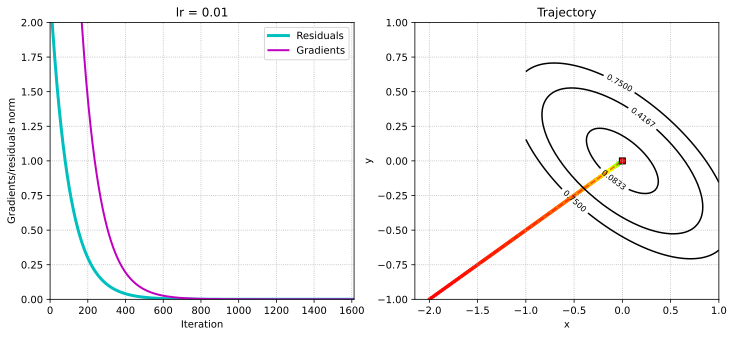

Execution time newton: 4.491989612579346 seconds
success 1405 iterations


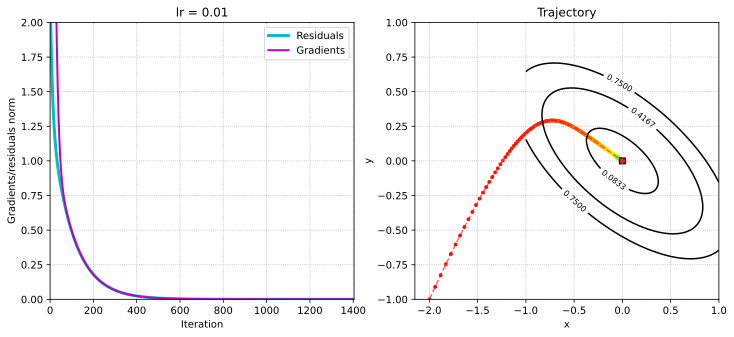

Execution time gd: 4.470465421676636 seconds


In [24]:
A = np.array([[2, 2], [2, 5]])
b = np.zeros(2)
oracle = QuadraticOracle(A, b)
x_opt, message, history = newton(oracle, np.zeros(2), 0.01)
print('Found optimal point: {}'.format(x_opt))
start_time = time.time()
test_2d("newton", oracle, np.array([-2, -1]), lr=0.01, tol=1e-6)
end_time = time.time()
execution_time = end_time - start_time  # Calculate the execution time
print("Execution time newton:", execution_time, "seconds")
start_time = time.time()
test_2d("gd", oracle, np.array([-2, -1]), lr=0.01, tol=1e-6)
end_time = time.time()
execution_time = end_time - start_time  # Calculate the execution time
print("Execution time gd:", execution_time, "seconds")


success 2463 iterations


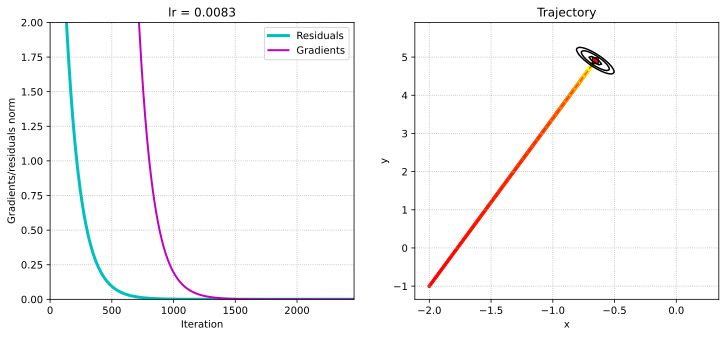

Execution time newton: 4.734241724014282 seconds
success 3166 iterations


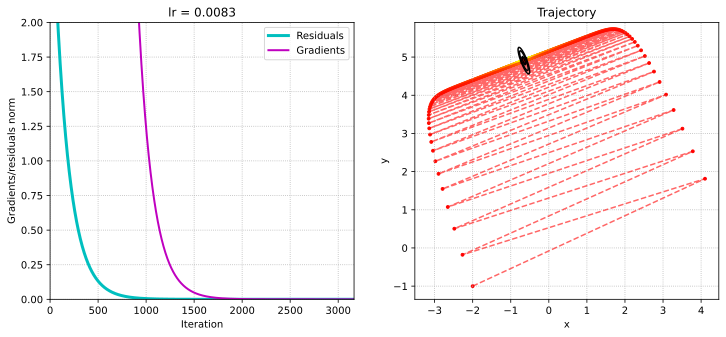

Execution time gd: 6.077919960021973 seconds


In [147]:
x_0 = np.zeros(2)
learning_rate = 0.0083 
boston.dropna(inplace=True)
boston.isnull().sum()
feature = pd.DataFrame(np.c_[boston['LSTAT'], boston['RM']], columns = ['LSTAT','RM']).values
target = boston['MEDV'].values
oracle = LinRegOracle(feature, target)
start_time = time.time()
test_2d("newton", oracle, np.array([-2, -1]), learning_rate, tol=1e-6)
end_time = time.time()
execution_time = end_time - start_time  # Calculate the execution time
print("Execution time newton:", execution_time, "seconds")
start_time = time.time()
test_2d("gd", oracle, np.array([-2, -1]),learning_rate, tol=1e-6)
end_time = time.time()
execution_time = end_time - start_time  # Calculate the execution time
print("Execution time gd:", execution_time, "seconds")

success 1646 iterations


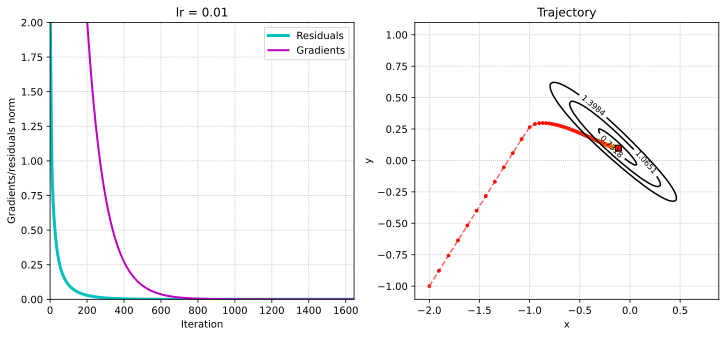

Execution time newton: 9.214567422866821 seconds
success 520 iterations


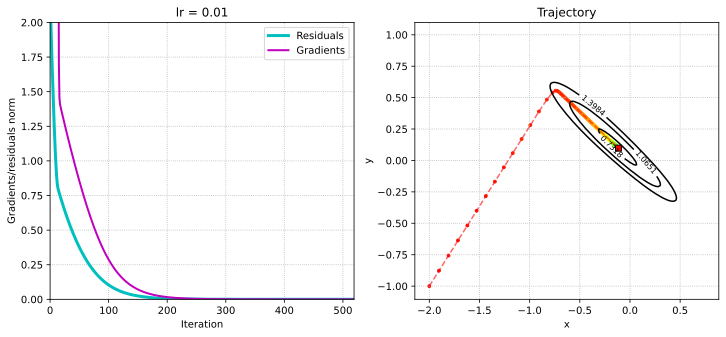

Execution time gd: 3.3742356300354004 seconds


In [152]:
y = breast['target']
y[y == 0] = -1
X = breast.data[:, [0, 1]]
X = np.array(X)
y = np.array(y)
oracle = LogRegOracle(X, y)
start_time = time.time()
test_2d("newton", oracle, np.array([-2, -1]), lr = 0.01, tol=1e-6)
end_time = time.time()
execution_time = end_time - start_time  # Calculate the execution time
print("Execution time newton:", execution_time, "seconds")
start_time = time.time()
test_2d("gd", oracle, np.array([-2, -1]),lr = 0.01, tol=1e-6)
end_time = time.time()
execution_time = end_time - start_time  # Calculate the execution time
print("Execution time gd:", execution_time, "seconds")

## GD vs Newton

### Task 6.13 (1 point)

Run both gradient descent and Newton's methods on full `boston` and `breast_cancer` datasets. Do they converge? How many iterations are required for convergence? How much time?

For Boston:

success 1646 iterations (Newton ) vs(Gd) success 3166 iterations

Execution time newton: 4.734241724014282 seconds

Execution time gd: 6.077919960021973 seconds

For Breast_cancer:

success 1646 iterations (Newton) vs (Gd) success 520 iterations

Execution time newton: 9.214567422866821 seconds

Execution time gd: 3.3742356300354004 seconds

My laptop has some troubles with memory.